<a href="https://colab.research.google.com/github/MateusMaruzka/LM_InlineAssembly/blob/main/calib_lowcostsensors_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Instalando as dependências:


1.   Tensorflow Decision Forests



In [1]:
!pip install tensorflow_decision_forests

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 16.2 MB 10.4 MB/s 
     |████████████████████████████████| 588.3 MB 6.7 kB/s 
     |████████████████████████████████| 439 kB 63.8 MB/s 
     |████████████████████████████████| 1.7 MB 51.6 MB/s 
     |████████████████████████████████| 6.0 MB 47.3 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 

In [27]:
import tensorflow as tf
import tensorflow_decision_forests as tfdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, \
                                    validation_curve, cross_val_score, \
                                    cross_validate, \
                                    RepeatedKFold


In [ ]:
df = pd.read_csv('sample_data/dataset.csv')
df.set_index('Date/Time', inplace = True)
df.dropna(inplace=True)

### Tukey's rule for outliers (IQR rule)

1. IQR =  Q3 - Q1
2. upper limit = Q3 + 1.5*IQR
3. lower limit = Q1 - 1.5*IQR

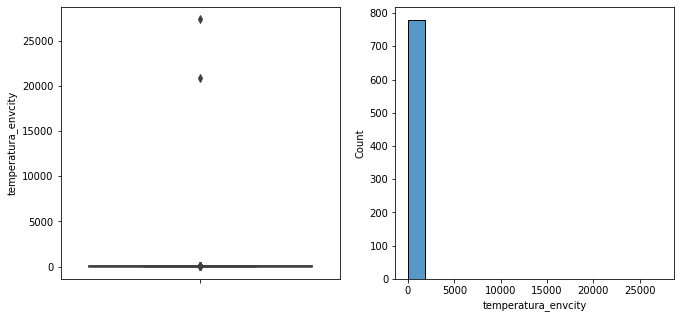

count      781.000000
mean        79.916641
std       1230.193020
min         11.959094
25%         16.000000
50%         18.722474
75%         19.834418
max      27375.000000
Name: temperatura_envcity, dtype: float64

In [96]:
l = 'temperatura_envcity'
def boxplot_histplot(data):
  fig, ax = plt.subplots(1, 2, figsize = (11,5))
  sns.boxplot(y = data, ax = ax[0])
  sns.histplot(data, ax = ax[1], bins = 15)
  plt.show()

boxplot_histplot(df[l])
df[l].describe()

In [97]:
Q1 = df[l].quantile(0.25)
Q3 = df[l].quantile(0.75)
IQR = Q3 - Q1
lower_lim = Q1 - 1.5*IQR
upper_lim = Q3 + 1.5*IQR
print(f'First quantile = {Q1}')
print(f'Third quantile = {Q3}')
print(f'IQR = {IQR}')
print(f'Lower limit = {lower_lim}')
print(f'upper limit = {upper_lim}')

First quantile = 16.0
Third quantile = 19.834417932031812
IQR = 3.834417932031812
Lower limit = 10.248373101952282
upper limit = 25.58604483007953


In [98]:
outliers = (df[l] < lower_lim) | (df[l] > upper_lim)
print(len(df[l][outliers]))
print(f'Outliers -> {len(df[l][outliers])*100 / len(df[l])} %')

17
Outliers -> 2.176696542893726 %


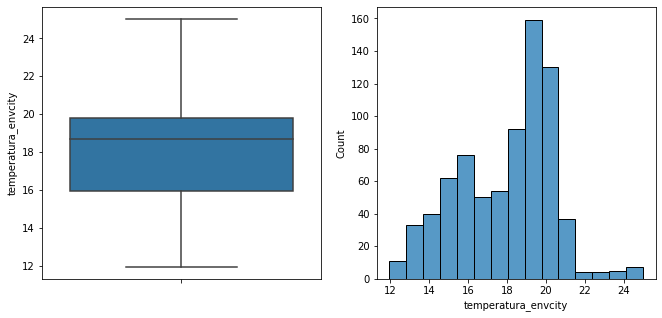

In [99]:
#  Dropping outliers
boxplot_histplot(df[l][~outliers])

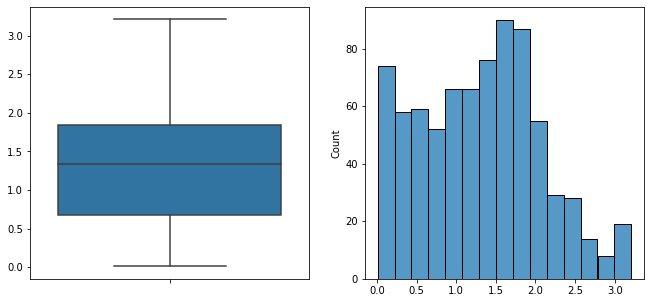

In [93]:
# Modifying outliers by winsorize method
from scipy.stats.mstats import winsorize

df_winsorize = winsorize(df[l], (0.01, 0.02))
boxplot_histplot(df_winsorize)

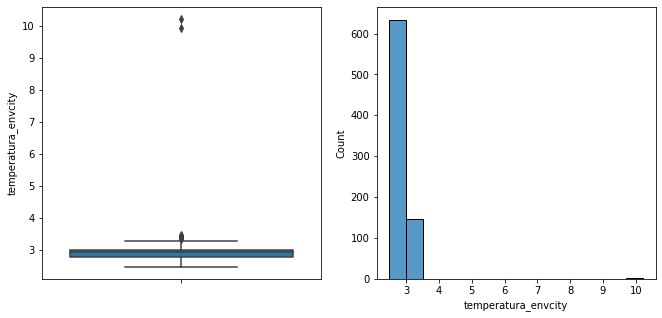

In [100]:
# Log transformation: reduces the skewness of data and tries to make it normal

df_log = np.log(df[l])
boxplot_histplot(df_log)

In [5]:
# Split the dataset into a training and a testing dataset.

def split_dataset(dataset, test_ratio=0.30):
  """Splits a panda dataframe in two."""
  test_indices = np.random.rand(len(dataset)) < test_ratio
  return dataset[~test_indices], dataset[test_indices]


In [6]:
label = 'co_iat'
label_envcity = 'co_envcity'
Yco = df[label]
Xco = df.loc[Yco.index][[label,'temperatura_envcity','umidade_envcity', label_envcity]]

train_ds_pd, test_ds_pd = split_dataset(Xco)
print("{} examples in training, {} examples for testing.".format(len(train_ds_pd), len(test_ds_pd)))

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)
test_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_ds_pd, label=label, task=tfdf.keras.Task.REGRESSION)


534 examples in training, 247 examples for testing.


In [7]:
# Train a Random Forest model.
model = tfdf.keras.RandomForestModel(task=tfdf.keras.Task.REGRESSION, verbose=0)
# model.fit(x=X_train, y=y_train)
model.fit(train_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


In [8]:
# Summary of the model structure.
model.summary()

Model: "random_forest_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1
Trainable params: 0
Non-trainable params: 1
_________________________________________________________________
Type: "RANDOM_FOREST"
Task: REGRESSION
Label: "__LABEL"

Input Features (3):
	co_envcity
	temperatura_envcity
	umidade_envcity

No weights

Variable Importance: MEAN_MIN_DEPTH:
    1.             "__LABEL"  8.604654 ################
    2.     "umidade_envcity"  2.238372 ###
    3. "temperatura_envcity"  1.883248 ##
    4.          "co_envcity"  0.645734 

Variable Importance: NUM_AS_ROOT:
    1.          "co_envcity" 187.000000 ################
    2.     "umidade_envcity" 86.000000 #####
    3. "temperatura_envcity" 27.000000 

Variable Importance: NUM_NODES:
    1. "temperatura_envcity" 7781.000000 ################
    2.          "co_envcity" 7727.000000 #########
    3.     "umidade_envcity" 7647.00

In [9]:
# Evaluate the model.
model.compile(metrics=["accuracy"])
evaluation = model.evaluate(test_ds, return_dict=True)
print()

for name, value in evaluation.items():
  print(f"{name}: {value:.4f}")

# Export the model to a SavedModel.
# model.save("project/model")

1/1 [==============================] - 1s 576ms/step - loss: 0.0000e+00 - accuracy: 0.0000e+00

loss: 0.0000
accuracy: 0.0000


In [10]:
tfdf.model_plotter.plot_model_in_colab(model, tree_idx=0)